In [38]:
%matplotlib notebook
from matplotlib import style
import matplotlib.pyplot as plt

In [39]:
import numpy as np
import pandas as pd

In [40]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [41]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [42]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [43]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [44]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [45]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [46]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

<IPython.core.display.Javascript object>


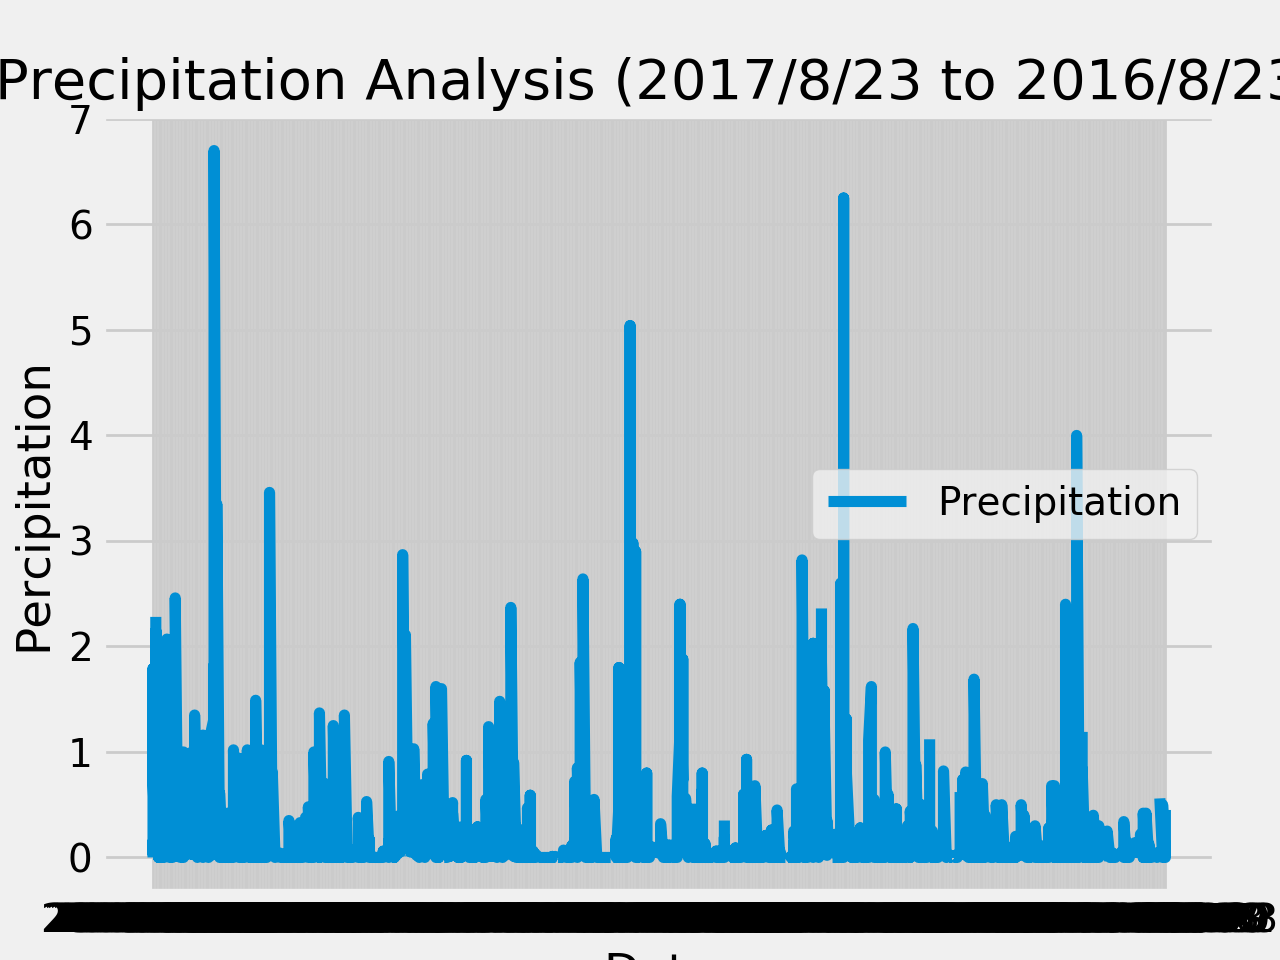

In [56]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from today
date = dt.date(2018, 10, 6) - dt.timedelta(days=365)
# Last date and year entry in data
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_year).order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(precipitation)
prcp_df.set_index('date', inplace=True)
# Sort the dataframe by date
prcp_df.sort_index(inplace=True)
# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(prcp_df.index, prcp_df['prcp'])
plt.xlabel('Date')
plt.ylabel('Percipitation')
plt.title('Precipitation Analysis (2017/8/23 to 2016/8/23)')
plt.legend(["Precipitation"])
plt.show()
# Rotate the xticks for the dates
plt.xticks(rotation=45)

In [57]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [58]:
# How many stations are available in this dataset?
stations = session.query(Station).count()
stations

9

In [59]:
# What are the most active stations?
# List the stations and the counts in descending order.
active_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).all()
active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [60]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
low_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
high_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
print(low_temp, high_temp, avg_temp)

[(54.0,)] [(85.0,)] [(71.66378066378067,)]


<IPython.core.display.Javascript object>


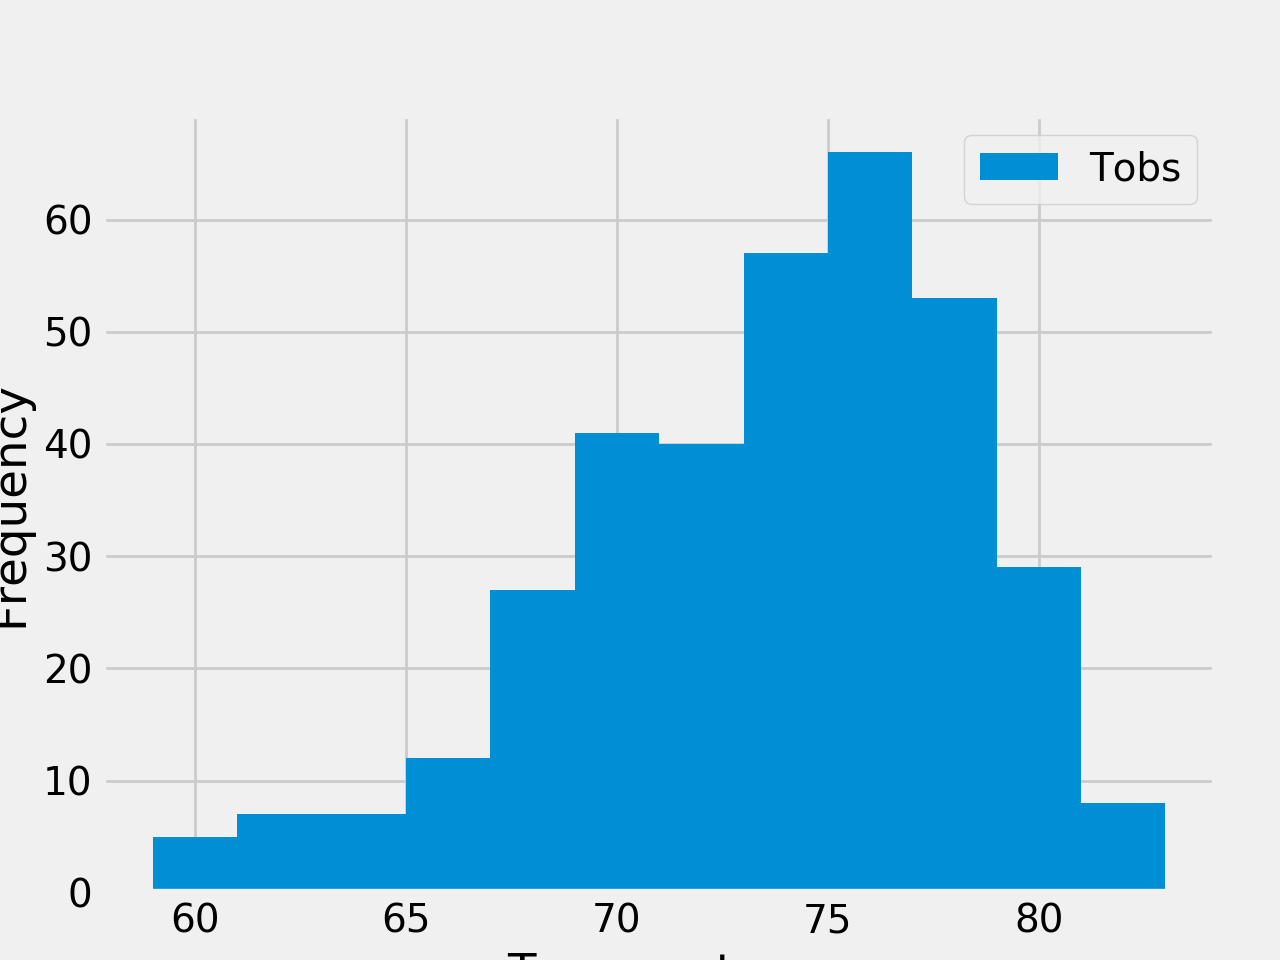

In [61]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obs = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
            filter(Measurement.station == 'USC00519281').\
            filter(Measurement.date >= last_year).\
            order_by(Measurement.date).all()
temp_df = pd.DataFrame(temp_obs)
temp_df.head(5)
# Plot the grapgh
temp_df.plot.hist(temp_df['tobs'], bins = 12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(["Tobs"])
#plt.show()